I can do all this through him who give me strength

In [1]:
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as pimg

In [2]:
# Train & Test Set Load
train = pd.read_csv("../data/train_users_2.csv")
test = pd.read_csv("../data/test_users.csv")
ss = pd.read_csv("../data/sample_submission_NDF.csv")

In [3]:
# 보조 데이터 Set
age_gender = pd.read_csv("../data/age_gender_bkts.csv")
countries = pd.read_csv("../data/countries.csv")
sessions = pd.read_csv("../data/sessions.csv")

In [4]:
# train / test columns 비교
set(train.columns) - set(test.columns)

{'country_destination'}

In [5]:
train.shape, test.shape

((213451, 16), (62096, 15))

In [6]:
test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [7]:
test.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
62095,9uqfg8txu3,2014-09-30,20140930235901,NaN,FEMALE,49.0,basic,0,en,other,other,tracked-other,Web,Windows Desktop,Chrome


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [9]:
train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [10]:
for col in train.columns:
    print("{col} : {count}".format(col=col, count=len(train[col].unique())))

id : 213451
date_account_created : 1634
timestamp_first_active : 213451
date_first_booking : 1977
gender : 4
age : 128
signup_method : 3
signup_flow : 17
language : 25
affiliate_channel : 8
affiliate_provider : 18
first_affiliate_tracked : 8
signup_app : 4
first_device_type : 9
first_browser : 52
country_destination : 12


In [11]:
train.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


## Age Modeling (# of NaN = 87,990)

또 다른 조사기관인 닐슨온라인(Nielsen Online)의 조사에서도 이와 유사한 경향이 나타났음. 젊은 계층에 비해 나이 든 미국인들의 온라인 활동 비율은 낮지만, 55세 이상에서는 2008년에 1/3 가량이 웹을 활용하고, 온라인에서 보내는 시간은 오히려 젊은 층보다 많은 것으로 나타남

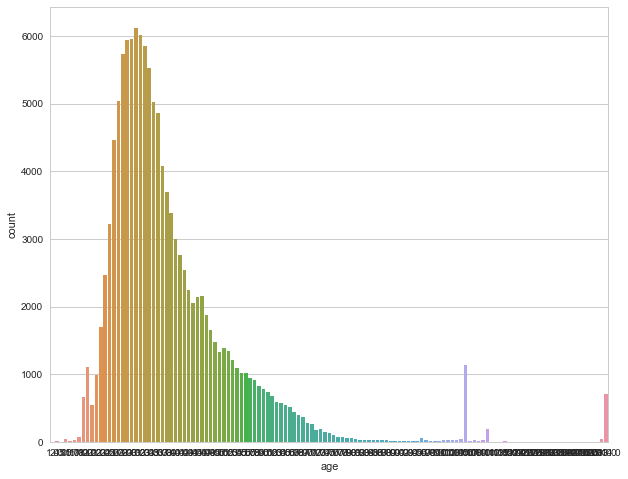

In [12]:
plt.figure(figsize=(10,8))

sns.countplot(x=train.age.dropna())
plt.show()

### 1.1 'Age' Preprocessing

In [13]:
indices = list(train.age[train.age == 2014].index)
for index in indices:
    train.loc[index, 'age'] = np.nan
    
indices = list(train.age[train.age == 2013].index)
for index in indices:
    train.loc[index, 'age'] = np.nan
    
indices = list(train.age[(train.age > 120) & (train.age < 200)].index)
for index in indices:
    train.loc[index, 'age'] = np.nan

In [14]:
train = train.copy()
indices = list(train.age[train.age > 120].index)
for index in indices:
    if train.loc[index, 'age'] > 1900:
        mod = 2015 - train.age.loc[index]
        train.loc[index, 'age'] = mod
train.tail()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [15]:
df = pd.DataFrame(columns = ["age", "age_bucket"])
df["age"] = list(range(0, 151))

age_bucket = list(age_gender.age_bucket.unique())
age_bucket.reverse()

for i in range(len(df)):
    if df.age[i] > 100:
        df.loc[i, "age_bucket"] = age_bucket[-1]
    else:
        df.loc[i, "age_bucket"] = age_bucket[i//5]

df = df.set_index("age")
df

,age_bucket
age,
0,0-4
1,0-4
2,0-4
3,0-4
4,0-4
5,5-9
6,5-9
7,5-9
8,5-9


In [16]:
train["age_bkt"] = train["age"].map(df.age_bucket)
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,35-39
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,55-59
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,40-44
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,40-44


#### Grouping

In [17]:
indices = list(train.age_bkt[(train.age_bkt == '0-4') | (train.age_bkt == '5-9') | 
                             (train.age_bkt == '10-14') | (train.age_bkt == '15-19')].index)

for index in indices:
    train.loc[index, 'age_bkt'] = 'minor'

In [18]:
indices = list(train.age[(train.age_bkt == '70-74') | (train.age_bkt == '75-79') |
                        (train.age_bkt == '80-84')| (train.age_bkt == '85-89')|
                        (train.age_bkt == '90-94')| (train.age_bkt == '95-99')| (train.age_bkt == '100+')].index)
for index in indices:
    train.loc[index, 'age_bkt'] = 'senior'

In [19]:
print(train.age.unique())

[ nan  38.  56.  42.  41.  46.  47.  50.  36.  37.  33.  31.  29.  30.
  40.  26.  32.  35.  59.  49.  44.  34.  28.  19.  53.  52.  39.  57.
  25.  54.  69.  63.  43.  55.  65.  58.  61.  18.   5.  27.  45.  60.
  48.  51.  64.  72.  70.  67.  73. 104.  66. 105.  68.  95.  24.  94.
  75.  79.  62.  16.   4.  23. 101.  98.  76.  74.  87.  92. 115.  71.
  84. 107.  78.  99. 110. 102.  82.  77.  22.  89.  21.  15.  20. 103.
   2.  17.  86.  97.  81.  90.  88.  80. 100.  91. 106.  83.  85. 108.
 113. 109.  93.  96. 111. 112.   1.   7.]


In [20]:
# check
train[train.age.isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,NaN
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR,NaN
16,2dwbwkx056,2010-01-07,20100107215125,NaN,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF,NaN
18,cxlg85pg1r,2010-01-08,20100108015641,NaN,-unknown-,NaN,basic,0,en,seo,facebook,NaN,Web,Other/Unknown,-unknown-,NDF,NaN
20,qdubonn3uk,2010-01-10,20100110152120,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,US,NaN
23,jha93x042q,2010-01-11,20100111224015,NaN,-unknown-,NaN,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF,NaN
26,bjg0m5otl3,2010-01-12,20100112155420,NaN,-unknown-,NaN,basic,0,en,other,other,untracked,Web,Other/Unknown,-unknown-,NDF,NaN
38,7yzz3iv0ji,2010-01-15,20100115234132,NaN,-unknown-,NaN,basic,0,en,sem-non-brand,other,omg,Web,Windows Desktop,Firefox,NDF,NaN
43,69xzq1jxkq,2010-01-21,20100121183725,NaN,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF,NaN


#### Fill NA to be filled based on distribution of existing values

In [21]:
dist = train.age_bkt.value_counts(normalize=True)
print(dist)

30-34     0.228939
25-29     0.217649
35-39     0.152506
40-44     0.094138
20-24     0.071422
45-49     0.067918
50-54     0.048521
55-59     0.035843
senior    0.026389
60-64     0.025106
65-69     0.016093
minor     0.015476
Name: age_bkt, dtype: float64


In [22]:
missing = train['age_bkt'].isnull()
train.loc[missing,'age_bkt'] = np.random.choice(dist.index, size=len(train[missing]), p=dist.values)

In [23]:
train[train['age'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,35-39
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US,40-44
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR,40-44
16,2dwbwkx056,2010-01-07,20100107215125,NaN,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF,55-59
18,cxlg85pg1r,2010-01-08,20100108015641,NaN,-unknown-,NaN,basic,0,en,seo,facebook,NaN,Web,Other/Unknown,-unknown-,NDF,40-44
20,qdubonn3uk,2010-01-10,20100110152120,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,US,25-29
23,jha93x042q,2010-01-11,20100111224015,NaN,-unknown-,NaN,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF,senior
26,bjg0m5otl3,2010-01-12,20100112155420,NaN,-unknown-,NaN,basic,0,en,other,other,untracked,Web,Other/Unknown,-unknown-,NDF,25-29
38,7yzz3iv0ji,2010-01-15,20100115234132,NaN,-unknown-,NaN,basic,0,en,sem-non-brand,other,omg,Web,Windows Desktop,Firefox,NDF,35-39
43,69xzq1jxkq,2010-01-21,20100121183725,NaN,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF,20-24


In [24]:
# check age_bkt distribution 
train.age_bkt.value_counts(normalize=True) * 100

30-34     22.935943
25-29     21.771742
35-39     15.191309
40-44      9.367489
20-24      7.136533
45-49      6.839040
50-54      4.893863
55-59      3.578339
senior     2.629175
60-64      2.497060
65-69      1.620512
minor      1.538995
Name: age_bkt, dtype: float64

### 1.2 Other Feature Preprocessing

#### affiliate_provider (전처리)

In [25]:
train.affiliate_provider.value_counts()

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

In [26]:
list_afiliate = train.affiliate_provider.value_counts()
df_afiliate = pd.DataFrame(list_afiliate)
afiliate_list = df_afiliate[df_afiliate['affiliate_provider']>500].index
afiliate_list
train['affiliate_provider'] = train['affiliate_provider'].apply(lambda x : x if x in afiliate_list else 'other')
train.affiliate_provider.value_counts()

direct                 137426
google                  51693
other                   14118
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
Name: affiliate_provider, dtype: int64

In [27]:
indices = list(train.affiliate_provider[(train.affiliate_provider == "facebook-open-graph")].index)
for index in indices:
    train.loc[index, 'affiliate_provider'] = "facebook"
train.affiliate_provider.value_counts()

direct        137426
google         51693
other          14118
craigslist      3471
facebook        2818
bing            2328
vast             829
padmapper        768
Name: affiliate_provider, dtype: int64

In [28]:
indices = list(train.affiliate_provider[(train.affiliate_provider == "vast")| (train.affiliate_provider == "padmapper")].index)
for index in indices:
    train.loc[index, 'affiliate_provider'] = "other"
train.affiliate_provider.value_counts()

direct        137426
google         51693
other          15715
craigslist      3471
facebook        2818
bing            2328
Name: affiliate_provider, dtype: int64

In [29]:
# check
train[train.affiliate_provider == 'facebook-open-graph'].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt


#### affiliate_channel (유지)

In [30]:
train.affiliate_channel.value_counts()

direct           137727
sem-brand         26045
sem-non-brand     18844
other              8961
seo                8663
api                8167
content            3948
remarketing        1096
Name: affiliate_channel, dtype: int64

#### first_device_type (전처리)

In [31]:
train.first_device_type.value_counts()

Mac Desktop           89600
Windows Desktop       72716
iPhone                20759
iPad                  14339
Other/Unknown         10667
Android Phone          2803
Android Tablet         1292
Desktop (Other)        1199
SmartPhone (Other)       76
Name: first_device_type, dtype: int64

In [32]:
indices = list(train.first_device_type[(train.first_device_type == "SmartPhone (Other)") | (train.first_device_type == "Desktop (Other)")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Other/Unknown"
train.first_device_type.value_counts()

Mac Desktop        89600
Windows Desktop    72716
iPhone             20759
iPad               14339
Other/Unknown      11942
Android Phone       2803
Android Tablet      1292
Name: first_device_type, dtype: int64

In [38]:
indices = list(train.first_device_type[(train.first_device_type == "iPhone") | (train.first_device_type == "iPad")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Mobile iOS"
train.first_device_type.value_counts()

Mac Desktop        89600
Windows Desktop    72716
Mobile iOS         35098
Other/Unknown      11942
Mobile Android      1949
Android Phone       1767
Android Tablet       379
Name: first_device_type, dtype: int64

In [39]:
indices = list(train.first_device_type[(train.first_device_type == "Android Phone") | (train.first_device_type == "Android Tablet")].index)
for index in indices:
    train.loc[index, 'first_device_type'] = "Mobile Android"
train.first_device_type.value_counts()

Mac Desktop        89600
Windows Desktop    72716
Mobile iOS         35098
Other/Unknown      11942
Mobile Android      4095
Name: first_device_type, dtype: int64

In [40]:
# check : Okay
train[train.affiliate_provider == 'iPhone'].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt


#### first_browser (전처리)

In [41]:
train.first_browser.value_counts()

Chrome                  63845
Safari                  45169
Firefox                 33655
-unknown-               27266
IE                      21068
Mobile Safari           19274
Chrome Mobile            1270
Android Browser           851
AOL Explorer              245
Opera                     188
Silk                      124
Chromium                   73
BlackBerry Browser         53
Maxthon                    46
IE Mobile                  36
Apple Mail                 36
Sogou Explorer             33
Mobile Firefox             30
SiteKiosk                  24
RockMelt                   24
Iron                       17
IceWeasel                  13
Pale Moon                  12
Yandex.Browser             11
CometBird                  11
SeaMonkey                  11
Camino                      9
TenFourFox                  8
wOSBrowser                  6
CoolNovo                    6
Opera Mini                  4
Avant Browser               4
Mozilla                     3
Opera Mobi

In [42]:
list_browser = train.first_browser.value_counts()
df_browser = pd.DataFrame(list_browser)
browser_list = df_browser[df_browser['first_browser']>100].index
train['first_browser'] = train['first_browser'].apply(lambda x : x if x in browser_list else 'other').replace('-unknown-', 'other')

In [43]:
train.first_browser.value_counts()

Chrome             63845
Safari             45169
Firefox            33655
other              27762
IE                 21068
Mobile Safari      19274
Chrome Mobile       1270
Android Browser      851
AOL Explorer         245
Opera                188
Silk                 124
Name: first_browser, dtype: int64

In [46]:
indices = list(train.first_browser[(train.first_browser == "AOL Explorer") | (train.first_browser == "Opera") | (train.first_browser == "Silk")].index)
for index in indices:
    train.loc[index, 'first_browser'] = "other"
train.first_browser.value_counts()

Chrome             63845
Safari             45169
Firefox            33655
other              28319
IE                 21068
Mobile Safari      19274
Chrome Mobile       1270
Android Browser      851
Name: first_browser, dtype: int64

In [47]:
# Check : Okay
train[train.first_browser == 'Opera']

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bkt


#### signup_app (유지)

In [48]:
train.signup_app.value_counts()

Web        182717
iOS         19019
Moweb        6261
Android      5454
Name: signup_app, dtype: int64

#### signup_ㅡmethod (유지)

In [49]:
train.signup_method.value_counts()

basic       152897
facebook     60008
google         546
Name: signup_method, dtype: int64

#### language (전처리 중)

In [59]:
lan_train = train.language.value_counts(normalize=True) * 100

In [58]:
lan_test = test.language.value_counts(normalize=True) * 100

In [74]:
lan_df = pd.concat([lan_train, lan_test], axis=1).reset_index()
lan_df.columns = ['language', 'train', 'test']
lan_df.sort_values(by='train', ascending=False)

,language,train,test
6,en,96.656375,95.374903
25,zh,0.764578,1.613631
9,fr,0.549072,0.541098
7,es,0.428670,0.417096
16,ko,0.349963,0.594241
4,de,0.342936,0.394550
14,it,0.240805,0.191639
21,ru,0.182243,0.191639
20,pt,0.112438,0.132054
15,ja,0.105411,0.193249


### 1.3 'Date' Preprocessing

### 1.4  데이터 탐색

In [ ]:
data1 = train.pivot_table(columns=['age_bkt'], index=['first_device_type', 'first_browser'], values='id', aggfunc="count")
data1

### Age Modeling

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score

In [ ]:
age_train = train[train.age_bkt.notnull()]
age_train

In [ ]:
age_test = train[train.age_bkt.isnull()]
age_test

In [ ]:
feature_names = ['signup_method', 'signup_app', 'affiliate_channel',
                 'affiliate_provider', 'first_device_type', 'first_browser']
dfX = age_train[feature_names].copy()
dfy = age_train['age_bkt'].copy()

In [ ]:
dfX.tail()

In [ ]:
dummies = ['signup_method', 'signup_app', 'affiliate_channel',
          'affiliate_provider', 'first_device_type', 'first_browser']
for feature in dummies:
    dummy_features = pd.get_dummies(dfX[feature], prefix=feature)
    for dummy in dummy_features:
        dfX[dummy] = dummy_features[dummy]
    dfX = dfX.drop([feature], 1)

In [ ]:
# 종속변수 Label Encoder
dfy2 = pd.DataFrame(LabelEncoder().fit_transform(dfy), index=dfy.index)
dfy2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=100, min_samples_leaf=1).fit(dfX, dfy2)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(dfy2, model.predict(dfX)))

In [ ]:
# pd.DataFrame(data=result[1:,1:], index=result[1:,0], columns=result[0,1:])

In [ ]:
command_buf = io.StringIO() 
export_graphviz(model, out_file=command_buf) 
graph = pydot.graph_from_dot_data(command_buf.getvalue())[0] 
image = graph.create_png()
#Image(image)
# newImg1 = pimg.new('RGB', (512,512))
# newImg1.pimg.save("img1.png")

## Feature selection 2

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfy2, test_size=0.25, random_state=0)

In [ ]:
n_estimators = 100
model_rf = RandomForestClassifier(max_depth=100, n_estimators=n_estimators).fit(dfX, dfy2)

In [ ]:
print(classification_report(dfy2, model_rf.predict(dfX)))

In [ ]:
importances = model_rf.feature_importances_

std = np.std([model_rf.feature_importances_ for tree in model_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(dfX.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

In [ ]:
dfX.columns[40]

In [ ]:
labels = age_train['age_bkt'].values
n_labels = len(set(labels))
n_test = dfX.shape[0]

In [ ]:
import xgboost as xgb
import operator

In [ ]:
params = {
    'objective': 'multi:softprob',
    'eval_metric': 'merror',
    'num_class': n_labels,
    'eta': 0.3,
    'max_depth': 6,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'silent': 1,
    'seed': 123
}

num_boost_round = 50

dtrain = xgb.DMatrix(dfX, dfy2)
res = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=5,
             callbacks=[xgb.callback.print_evaluation(show_stdv=True),
                        xgb.callback.early_stop(1)])

In [ ]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round)

In [ ]:
importance = clf.get_fscore()
importance_df = pd.DataFrame(
    sorted(importance.items(), key=operator.itemgetter(1)),
    columns=['feature', 'fscore']
)
importance_df = importance_df.iloc[-20:, :]

In [ ]:
plt.figure()
importance_df.plot(kind='barh', x='feature', y='fscore',
                   legend=False, figsize=(30, 12))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance.png')

In [ ]:
dtest = xgb.DMatrix(dfX)
y_pred = clf.predict(dtest).reshape(n_test, n_labels)

In [ ]:
ids = []
ages = []
for i in range(len(n_test)):
    idx = test_id[i]
    ids += [idx] * 5
    ages += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()


## 변외 - 세대구분

In [ ]:
train2 = train

bins = [0, 30, 60, 100]
group_names = ["younger", "family", "older"]
train2['group_age'] = pd.cut(train['age'], bins, labels=group_names, right=False)

In [ ]:
train2['group_age'].dropna(axis=0, how='any')

In [ ]:
younger = sum(train2['group_age'] == 'younger')
family = sum(train2['group_age'] == 'family')
older = sum(train2['group_age'] == 'older')

younger_destinations = train2.loc[train2['group_age'] == 'younger', 'country_destination'].value_counts() / younger * 100
family_destinations = train2.loc[train2['group_age'] == 'family', 'country_destination'].value_counts() / family * 100
older_destinations = train2.loc[train2['group_age'] == 'older', 'country_destination'].value_counts() / older * 100

print("young", "\n", younger_destinations,"\n", "family", "\n", family_destinations,"\n", "older", "\n", older_destinations)

plt.figure(figsize=(10,8))
younger_destinations.plot(kind='bar', width=0.2, color='r', position=0, label='Youngers', rot=0)
family_destinations.plot(kind='bar', width=0.2, color='b', position=1, label='Family', rot=0)
older_destinations.plot(kind='bar', width=0.2, color='g', position=2, label='Olders', rot=0)


plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

plt.show()


In [ ]:
train2 = train

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
group_names = ["u10", "10g", "20g", "30g", "40g", "50g", "60g", "70g",
              "80g", "90g"]
train2['group_gen'] = pd.cut(train2['age'], bins, labels=group_names, right=False)
train2['group_gen'].dropna(axis=0, how='any')

### 세대별 여행지 선택

In [ ]:
data3_2 = train2.groupby('group_gen').aggregate({'id':'count'}).reset_index()
data3_2

In [ ]:
data3_2 = train2.pivot_table(columns='group_gen', index=['country_destination'],values='id', aggfunc="count")
data3_2.fillna(0)

In [ ]:
plt.figure(figsize=(10,8))
labels = 'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other'
sizes = data3_2['20g'].values.tolist()
plt.pie(sizes, autopct='%1.1f%%', labels=labels, shadow=True, startangle=140)
plt.tight_layout()
plt.show()